<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/ario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling the Role of Inventories and Heterogeneity in the Assessment of the Economic Costs of Natural Disasters


This workshop is based on [a paper](https://onlinelibrary.wiley.com/doi/abs/10.1111/risa.12090) by Stephane Hallegate, the paper presents the Adaptive Regional Input-Output (ARIO) model, which analyzes the economic impacts of natural disasters. Let me break down the key aspects:
Key Model Features:

**Based on input-output tables but extends traditional IO models by:**

+ Accounting for sector production capacities
+ Modeling both forward and backward economic propagation effects
+ Introducing adaptive behaviors in disaster aftermath
+ Including price dynamics

### How it Works
**The model tracks:**

+ Production bottlenecks in industries
+ Changes in demand patterns
+ Price variations and reconstruction costs
+ Employment impacts
+ Adaptation behaviors of economic agents

### Key Parameters

**Overproduction parameters:**

+ αmax: Maximum overproduction capacity (120%)
+ τα: Time needed to reach maximum production (6 months)
+ αb: Initial overproduction capacity (100%)

**Adaptation parameters:**

+ Response times for local final demand (τLFD)
+ Export demand (τE)
+ Intermediate consumption (τA)

**Price and demand parameters:**

+ ξ: Price elasticity
+ γp: Price response to production-demand imbalance

### Data Used

+ Input-Output tables from U.S. Bureau of Economic Analysis
+ Louisiana state-level economic data:


+ Gross state product by industry
+ Employment data
+ Production levels

### Katrina damage estimates


+ $107 billion in direct losses

+ Distributed across sectors

### Key Findings

+ Total economic losses reached $149 billion

+ The relationship between direct and total losses is nonlinear

+ When direct losses exceed $200B, total losses can be twice as large

+ Reconstruction took approximately 8 years to complete


**The model successfully reproduced many observed post-Katrina economic impacts, including:**

+ 8% initial reduction in production
+ Employment losses of 175,000 jobs
+ Construction sector dynamics
+ Price increases in reconstruction-related sectors

This framework provides important insights for disaster risk management by showing how economic amplification effects can significantly increase total costs beyond direct damage estimates.

# Load the module

In [1]:
!wget https://github.com/asrenninger/urbansim/raw/refs/heads/main/miscellany/ario.zip
!unzip ario.zip

--2025-02-26 08:41:06--  https://github.com/asrenninger/urbansim/raw/refs/heads/main/miscellany/ario.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/asrenninger/urbansim/refs/heads/main/miscellany/ario.zip [following]
--2025-02-26 08:41:06--  https://raw.githubusercontent.com/asrenninger/urbansim/refs/heads/main/miscellany/ario.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1925781 (1.8M) [application/zip]
Saving to: ‘ario.zip’

ario.zip            100%[===================>]   1.84M  --.-KB/s    in 0.07s   

2025-02-26 08:41:07 (25.1 MB/s) - ‘ario.zip’ saved [1925781/1925781]

Archive: 

In [2]:
import os
os.chdir('ario')

In [3]:
from scipy.io import loadmat, savemat

In [4]:
import numpy as np

# ARIO Model Simulation (Teaching Material)

This notebook illustrates the Adaptive Regional Input‐Output (ARIO) model,
which simulates the impact of a disaster (e.g. Katrina) on the Louisiana economy.

The simulation is broken into several steps:
1. **Parameter Initialization:** Set default parameters and simulation settings.
2. **Array Initialization:** Prepare arrays for storing simulation variables.
3. **Load Economic Data:** Import Louisiana economic data (IO table, Imports, Exports, etc.).
4. **Inventory & Stock Initialization:** Set up inventory and stock parameters.
5. **Load Disaster Data:** Import and scale disaster data, then initialize destruction.
6. **Additional Initializations:** Other variables (labor, macro effects, etc.).
7. **Main Simulation Loop:** Update production, demand, stocks, and finances day‐by‐day.
8. **Post-Simulation Analysis:** Compute quarterly averages, growth rates, and losses.
9. **Save Results:** Write key outputs to a file.

Diagnostic plots are included in a few steps to help visualize key dynamics.

In [5]:
import matplotlib.pyplot as plt


## 1. Parameter Initialization

In this section we define a helper function to set default parameters
and simulation settings.

In [6]:
def initialize_parameters(sens_ana=False, ampl=1.0, maxmax_surcapa=None,
                          tau_alpha=None, NbJourStockU=None, Tau_Stock=None, Adj_prod=None):
    # Print model header
    print('*******************************************************************')
    print('Adaptive Regional Input-Output (ARIO) model by Stéphane Hallegatte, version 4.1')
    print('Copyright (C) 2007-2009 Stéphane Hallegatte and Météo-France')
    print('Applied on the Louisiana economy and the landfall of Katrina (2005)')
    print('*******************************************************************')

    # Set default values if not provided
    if maxmax_surcapa is None:
        maxmax_surcapa = 1.25 * np.ones((1, 15))
    if tau_alpha is None:
        tau_alpha = 1.0
    if NbJourStockU is None:
        NbJourStockU = 90
    if Tau_Stock is None:
        Tau_Stock = 30/365.0
    if Adj_prod is None:
        Adj_prod = 0.8

    # If not doing sensitivity analysis, use reference parameters
    if not sens_ana:
        maxmax_surcapa = 1.25 * np.ones((1, 15))
        tau_alpha = 1.0
        NbJourStockU = 90
        Tau_Stock = 30/365.0
        ampl = 1.0
        Adj_prod = 0.8

    # Simulation settings
    Dtime = 1/365.0         # Time step (1 day in years)
    NStep = int(365 * 10)   # Total simulation steps (10 years)
    N = 15                  # Number of sectors

    return ampl, maxmax_surcapa, tau_alpha, NbJourStockU, Tau_Stock, Adj_prod, Dtime, NStep, N

# Initialize parameters (you can later modify these as needed)
ampl, maxmax_surcapa, tau_alpha, NbJourStockU, Tau_Stock, Adj_prod, Dtime, NStep, N = initialize_parameters()


*******************************************************************
Adaptive Regional Input-Output (ARIO) model by Stéphane Hallegatte, version 4.1
Copyright (C) 2007-2009 Stéphane Hallegatte and Météo-France
Applied on the Louisiana economy and the landfall of Katrina (2005)
*******************************************************************


## 2. Array Initialization

We create arrays to hold simulation variables such as production, imports,
stocks, and other economic measures. All arrays are pre-allocated for efficiency.


In [7]:
# Main simulation arrays (dimensions: time steps × sectors)
OK               = np.zeros((NStep+1, N))
OK_final         = np.zeros((NStep+1, N))
actual_housing_loss = np.zeros((NStep+1, 1))
actual_prod      = np.zeros((NStep+1, 1))
actual_Imports   = np.zeros((NStep+1, N))
actual_Exports   = np.zeros((NStep+1, N))
actual_Local_Dem = np.zeros((NStep+1, N))
actual_Dem_Exports = np.zeros((NStep+1, N))
actual_final_cons = np.zeros((NStep+1, N))
actual_Sales     = np.zeros((NStep+1, N))
Final_Dem_Sat    = np.zeros((NStep+1, N))
actual_L         = np.zeros((NStep+1, N))
total_L          = np.zeros(NStep+1)
avalanche        = np.zeros((NStep+1, 1))
Destr            = np.zeros(N)
Debt             = np.zeros((NStep+1))
prix             = np.ones((NStep+1, N))
payback          = np.zeros((NStep+1))
macro_effect     = np.ones(NStep+1)
Dem_recon_t      = np.zeros((NStep, N))
actual_reconstr  = np.zeros((NStep+1, 1))
old_actual_final_cons = np.zeros((NStep+1, N))
old_actual_recon_t = np.zeros((NStep, N))
Sales_tot        = np.zeros((NStep+1, N))
Dem_reconstr     = np.zeros((NStep+1, N, N))
Budget           = np.zeros(NStep+1)

# Additional timescales and constants
tau_recon = 1/4.0  # Reconstruction timescale
tauR      = 2.0    # Debt reimbursement timescale
epsilon   = 1.e-6  # Small number to avoid division-by-zero


## 3. Load Economic Data

Economic data (from Louisiana.mat) is loaded here.
The data includes the input-output table, Imports, Exports, Local Demand, etc.
We also convert these data using an exchange rate.


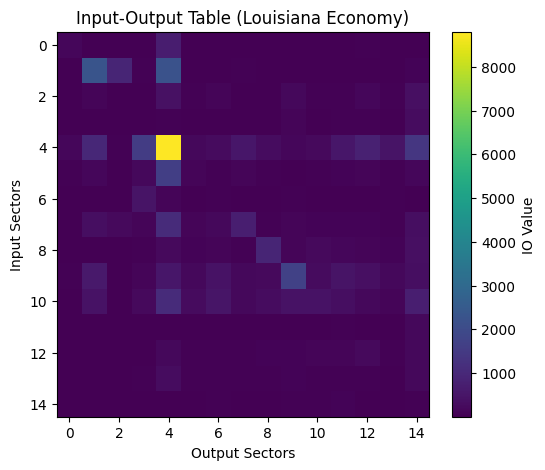

In [8]:
# Load economic data
louis_data = loadmat('Louisiana.mat')
ratio_K2Y       = louis_data['ratio_K2Y'].ravel()
T_Louis         = louis_data['T_Louis'].ravel()
L_Louis         = louis_data['L_Louis'].ravel()
IO_Table_Louis  = louis_data['IO_Table_Louis']
Imports_Louis   = louis_data['Imports_Louis'].ravel()
Exports_Louis   = louis_data['Exports_Louis'].ravel()
Local_Dem_Louis = louis_data['Local_Dem_Louis'].ravel()
Job_Louis       = louis_data['Job_Louis'].ravel()

# Exchange rate conversion (if applicable)
exchange_rate = 1.0
T       = T_Louis * exchange_rate
L       = L_Louis * exchange_rate
IO      = IO_Table_Louis * exchange_rate
Imports = Imports_Louis * exchange_rate
Exports = Exports_Louis * exchange_rate
Local_Dem = Local_Dem_Louis * exchange_rate

# Additional initial variables
max_surcapa = np.ones(N) * 1.0
Imports_C   = Local_Dem.copy()  # Consumption-related imports
actual_Imports_C = np.zeros(N)

# Economic parameters
penetration  = 1.0  # Household insurance penetration
penetrationf = 1.0  # Business insurance penetration
alpha        = 0.5
wage         = 1.0

# Calculate intermediate consumption and sales per sector from the IO table
Conso  = np.zeros(N)
Sales  = np.zeros(N)
for i in range(N):
    Conso[i] = np.sum(IO[:, i])  # Sum over rows (inputs for sector i)
    Sales[i] = np.sum(IO[i, :])  # Sum over columns (outputs from sector i)
Sales_ini = Sales.copy()

# Initialize production and value-added arrays
Produc      = np.zeros((NStep+1, N))
Long_Produc = np.zeros((NStep+1, N))
Profit      = np.zeros((NStep+1, N))
Prof_rate   = np.zeros((NStep+1, N))
VA          = np.zeros((NStep+1, N))
for i in range(N):
    Produc[0, i]      = Exports[i] + Local_Dem[i] + Sales[i]
    Long_Produc[0, i] = Produc[0, i]
    Profit[0, i]      = Produc[0, i] - (Conso[i] + wage * L[i] + Imports[i])
    VA[0, i]          = Produc[0, i] - Conso[i] - Imports[i]

# Initial assets and profit rates
Assets    = VA[0, :] * ratio_K2Y * exchange_rate
Prof_rate[0, :] = Profit[0, :] / T
Local_Dem_ini   = Local_Dem.copy()
Total_Local_Dem_ini = np.sum(Local_Dem_ini)
Exports_ini     = Exports.copy()
actual_final_cons[0, :] = Local_Dem
actual_prod[0]  = np.sum(Produc[0, :])

Pi      = (1 - alpha) * np.sum(Profit[0, :])
DL_ini  = wage * np.sum(L) + alpha * np.sum(Profit[0, :]) + Pi
A_initial = IO  # For record

# Diagnostic Plot: Visualize the IO table
plt.figure(figsize=(6, 5))
plt.imshow(IO, cmap='viridis', aspect='auto')
plt.colorbar(label='IO Value')
plt.title('Input-Output Table (Louisiana Economy)')
plt.xlabel('Output Sectors')
plt.ylabel('Input Sectors')
plt.show()



## 4. Inventory and Stock Initialization

Set up inventory parameters:
- NbJourStock: Number of days of stock for each sector.
- Adjustments for non-stockable goods (e.g., utilities, transportation).
- Initialize stock matrices and order matrices.

In [10]:
Sub_Del   = np.ones(N)     # Substitution delays (if any)
NoStock   = np.zeros(N)    # Indicator for non-stockable goods
NbJourStock = NbJourStockU * np.ones(N)  # Default days of stock

# Adjust non-stockable sectors (using 0-based indexing)
# Utilities (sector index 2)
NoStock[2]   = 1
NbJourStock[2] = 3.0 * NbJourStockU / 60.0
# Transportation (sector index 5)
NoStock[5]   = 1
NbJourStock[5] = 3.0 * NbJourStockU / 60.0
# Construction (sector index 3) gets a very high stock level
NbJourStock[3] = 365 * 100000

# Initialize stock and order matrices (dimensions: sectors × sectors)
Stock   = np.zeros((N, N))
Long_ST = np.zeros((N, N))
Order   = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Stock[i, j]   = IO[i, j] * NbJourStock[i] / 365.0
        Long_ST[i, j] = Stock[i, j]
        Order[i, j]   = IO[i, j]


## 5. Load Disaster Data and Initial Destruction Setup
We load the disaster (Katrina) data from a MATLAB file, scale it using 'ampl', and initialize the reconstruction demand (Dem_reconstr_ini) and destruction ratio (Destr).


In [11]:
# Load disaster data from file
kat_data = loadmat('Katrina_CBO_small.mat')
Table_Katrina = kat_data['Table_Katrina']

# Scale the disaster data by the amplification factor
Table_Dis_Louis = np.zeros((N+1, N))
for i in range(N+1):
    for j in range(N):
        Table_Dis_Louis[i, j] = Table_Katrina[i, j] * ampl

# Initialize reconstruction demand (Dem_reconstr_ini) using the scaled disaster data
Dem_reconstr_ini = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Dem_reconstr_ini[i, j] = Table_Dis_Louis[i, j]

# Compute initial destruction ratio per sector
Destr_capital_ini = np.sum(Dem_reconstr_ini, axis=1)
Destr_ini = Destr_capital_ini / (ratio_K2Y * VA[0, :])
Destr = Destr_ini.copy()
mem_Destr = np.zeros((NStep+1, N))
mem_Destr[0, :] = Destr

print('Disaster data loaded')


Disaster data loaded


## 6. Additional Initializations

Here we set up further variables:
- Labor, macroeconomic multipliers, adjusted production factors,
- Memory arrays for diagnostic tracking (e.g., mem_surcapa, mem_dem_recon).


In [12]:
Workers = np.zeros((NStep+1, N))
actual_W = np.zeros((NStep+1, N))
macro_effect[0] = 1.0

# Adjusted production smoothing
Adj_produc = Adj_prod * np.ones(N)
Needed_Stock = np.zeros((N, N))
Stock_target = np.zeros((N, N))
Supply = np.zeros((N, N))
mem_surcapa = np.zeros((NStep+1, N))
mem_surcapa[0, :] = max_surcapa

mem_dem_recon   = np.zeros((NStep+1, N))
mem_dem_export  = np.zeros((NStep+1, N))
mem_dem_local   = np.zeros((NStep+1, N))
mem_tot_order   = np.zeros((NStep+1, N))
mem_demand_total = np.zeros((NStep+1, N))
mem_out_sec     = np.zeros((NStep+1, N))
mem_qui_out_sec = np.zeros((NStep+1, N))

actual_recon_t = np.zeros((NStep+1, N))
actual_recon_t[0, :] = 0.0
mem_local_dem  = np.zeros((NStep, N))
rec_actual_Imports_C = np.zeros((NStep+1, N))

# Set initial values for OK and reconstruction demand arrays
for i in range(N):
    OK[0, i] = 1 - Destr[i]
    for j in range(N):
        Dem_reconstr[0, i, j] = Dem_reconstr_ini[i, j]

actual_prod[0] = np.sum(Produc[0, :])
total_L[0]     = np.sum(L)
actual_L[0, :] = L
actual_Imports[0, :] = Imports
actual_Exports[0, :]  = Exports
actual_Local_Dem[0, :] = Local_Dem

# Profit tracking arrays
tot_profit = np.zeros(NStep+1)
tot_profit[0] = np.sum(Profit[0, :])
reconstr_array = np.zeros((NStep+1, N))


## 7. Main Simulation Loop

The following loop simulates day-by-day changes over 10 years.
Each iteration (k) represents one day.

The loop performs:
1. **Overproduction Modeling:** Adjust capacity (max_surcapa) based on production shortfall.
2. **Demand Calculations:** Compute local demand, exports, reconstruction demand, and total demand.
3. **Production Limits:** Cap production at maximum available capacity.
4. **Stocks Constraint:** Adjust production based on inventory availability.
5. **Satisfied Demands:** Apply proportional rationing.
6. **Stock Update:** Update inventories based on supply/demand.
7. **New Orders:** Compute new order quantities.
8. **Economic Update:** Recalculate consumption, imports, VA, labor, and profits.
9. **Reconstruction Modeling:** Update reconstruction demand and destruction level.
10. **Household Budget & Macro Effects:** Update household budget and macro multiplier.


In [13]:
# Inline comments explain each step.
print('Start simulation')
for k in range(NStep):
    # Print progress each simulated year
    if (k % 365) == 364:
        print('Year:', (k // 365), 'completed')

    # --- 1. Overproduction Modeling ---
    if k > 0:
        for i in range(N):
            if OK_final[k, i] < (1 - epsilon):
                max_surcapa[i] += Dtime / tau_alpha * (1 - OK_final[k, i]) * (maxmax_surcapa[0, i] - max_surcapa[i])
            if OK_final[k, i] > (1 - epsilon):
                max_surcapa[i] += (1 - max_surcapa[i]) * Dtime / tau_alpha
    mem_surcapa[k+1, :] = max_surcapa

    # --- 2. Demand Calculations ---
    for i in range(N):
        actual_Local_Dem[k+1, i] = macro_effect[k] * Local_Dem[i]
        actual_Imports_C[i] = macro_effect[k] * Imports_C[i]
        actual_Exports[k+1, i] = Exports[i]

        # Reconstruction demand (sum over sectors j)
        Dem_recon_t[k, i] = np.sum(Dem_reconstr[k, :, i])
        if Dem_recon_t[k, i] > 0:
            actual_recon_t[k+1, i] = Dem_recon_t[k, i] / tau_recon
        else:
            actual_recon_t[k+1, i] = 0
        mem_dem_recon[k+1, i] = actual_recon_t[k+1, i]
        mem_dem_export[k+1, i] = actual_Exports[k+1, i]
        mem_dem_local[k+1, i]  = actual_Local_Dem[k+1, i]

    # Total demand: Exports + Local Demand + Reconstruction + Intermediate Consumption
    Demand_total = np.zeros((NStep+1, N))
    Demand_total[k+1, :] = actual_Exports[k+1, :] + actual_Local_Dem[k+1, :] + actual_recon_t[k+1, :]
    for i in range(N):
        for j in range(N):
            Demand_total[k+1, i] += Order[i, j]
            mem_tot_order[k+1, i] += Order[i, j]
        Produc[k+1, i] = Demand_total[k+1, i]
        mem_demand_total[k+1, i] = Demand_total[k+1, i]

    # --- 3. Production Limits ---
    max_prod = np.maximum(0, max_surcapa * Produc[0, :] * (1 - Destr))
    for i in range(N):
        if Produc[k+1, i] > max_prod[i]:
            Produc[k+1, i] = max_prod[i]
        OK_final[k+1, i] = min(1, Produc[k+1, i] / Demand_total[k+1, i])

    # --- 4. Stocks Constraint ---
    for j in range(N):
        out_sec = np.ones(N)
        for i in range(N):
            Needed_Stock[i, j] = (Produc[k+1, j] / Produc[0, j]) * IO[i, j] * NbJourStock[i] / 365.0
            if Needed_Stock[i, j] > 0:
                if Stock[i, j] < (Adj_produc[i] * Needed_Stock[i, j]):
                    out_sec[i] = max(0, 1 - (Adj_produc[i] * Needed_Stock[i, j] - Stock[i, j]) / (Adj_produc[i] * Needed_Stock[i, j]))
        Produc[k+1, j] *= np.min(out_sec)
        mem_out_sec[k+1, j] = Produc[k+1, j]
        mem_qui_out_sec[k+1, j] = np.argmin(out_sec)

    # --- 5. Satisfied Demands (Proportional Rationing) ---
    for i in range(N):
        factor = Produc[k+1, i] / Demand_total[k+1, i]
        actual_recon_t[k+1, i] *= factor
        actual_Exports[k+1, i] *= factor
        actual_final_cons[k+1, i] = actual_Local_Dem[k+1, i] * factor
        for j in range(N):
            Supply[i, j] = Order[i, j] * factor
        Final_Dem_Sat[k+1, i] = Produc[k+1, i] - Demand_total[k+1, i]

    # --- 6. Update Stocks ---
    for i in range(N):
        for j in range(N):
            Stock[i, j] = max(epsilon, Stock[i, j] - Dtime * (Produc[k+1, j] / Produc[0, j]) * IO[i, j] + Dtime * Supply[i, j])

    # --- 7. New Orders ---
    for i in range(N):
        for j in range(N):
            Stock_target[i, j] = (min(Demand_total[k+1, j], max_prod[j]) / Produc[0, j]) * IO[i, j] * NbJourStock[i] / 365.0
            tau_stock_target = 60.0 / 365.0
            Long_ST[i, j] = Long_ST[i, j] + Dtime / tau_stock_target * (Stock_target[i, j] - Long_ST[i, j])
            Order[i, j] = max(epsilon, (Produc[k+1, j] / Produc[0, j]) * IO[i, j] +
                              (Long_ST[i, j] - Stock[i, j]) / (Tau_Stock * NbJourStock[i] / NbJourStockU))

    # --- 8. Update Economic Variables ---
    for i in range(N):
        Conso[i] = 0
        actual_Imports[k+1, i] = Imports[i] * Produc[k+1, i] / Produc[0, i]
        VA[k+1, i] = Produc[k+1, i] - actual_Imports[k+1, i]
        for j in range(N):
            if IO[j, i] > 0:
                VA[k+1, i] -= IO[j, i] * Produc[k+1, i] / Produc[0, i]
                Conso[i] += prix[k+1, j] * IO[j, i] * Produc[k+1, i] / Produc[0, i]
        actual_W[k+1, i] = Job_Louis[i] * VA[k+1, i] / VA[0, i]
        actual_L[k+1, i] = L[i] * Produc[k+1, i] / Produc[0, i]
        Profit[k+1, i] = Produc[k+1, i] - (Conso[i] + actual_L[k+1, i] + actual_Imports[k+1, i])
        tot_profit[k+1] = np.sum(Profit[k+1, :])
        Prof_rate[k+1, i] = Profit[k+1, i] / T[i]
    total_L[k+1] = np.sum(actual_L[k+1, :])

    # --- 9. Reconstruction Modeling ---
    for i in range(N):
        if Destr[i] > 0:
            val = Dem_reconstr[k, i, :]
            sum_val = np.sum(val)
            if sum_val > 0:
                fraction = actual_recon_t[k+1, i] / Dem_recon_t[k, i] if Dem_recon_t[k, i] > 0 else 0
                Dem_reconstr[k+1, i, :] = np.maximum(0, Dem_reconstr[k, i, :] - Dtime * val * fraction)
            reconstr_array[k+1, i] = max(0, np.sum(Dem_reconstr[k, i, :]) - np.sum(Dem_reconstr[k+1, i, :]))
        Destr[i] = np.sum(Dem_reconstr[k+1, i, :]) / Assets[i]
        mem_Destr[k+1, i] = Destr[i]
    actual_prod[k+1] = np.sum(Produc[k+1, :])

    # --- 10. Household Budget and Macro Effects ---
    Budget[k+1] = Budget[k] + ((wage * np.sum(actual_L[k, :]) + alpha * tot_profit[k] + Pi)
                               - np.sum(actual_Imports_C) - np.sum(actual_final_cons[k, :])) / 12
    rec_actual_Imports_C[k+1, :] = actual_Imports_C
    macro_effect[k+1] = (DL_ini + 12 * (1 / tauR) * Budget[k+1]) / DL_ini
    mem_local_dem[k, :] = Local_Dem


Start simulation
Year: 0 completed
Year: 1 completed
Year: 2 completed
Year: 3 completed
Year: 4 completed
Year: 5 completed
Year: 6 completed
Year: 7 completed
Year: 8 completed
Year: 9 completed



## 8. Post-Simulation Analysis and Diagnostics

After the simulation loop, we compute:
- Quarterly average Value Added (VA_q)
- Relative VA over time (VA_rel)
- Annual VA for selected years and the corresponding growth rates.

We also print key loss metrics.

Total direct losses (million): 63091.09
Total VA Losses (absolute, million): -316515.40165097895
Total VA Losses (relative, %): -241.25553503108068
Per sector VA losses (absolute, million USD): [ -2085.06757032 -37518.0786957  -14538.89920022  -5353.56026267
 -12467.11798077 -17193.44199403 -25887.0471596  -21036.08642217
  -9237.87255771 -52514.04359694 -19877.28578086 -26819.36133063
 -17030.59295831  -8467.24358941 -46489.70255162]
Growth 2005 vs 2004: -4.793050411211064
Growth 2006 vs 2004: -41.04830747848388


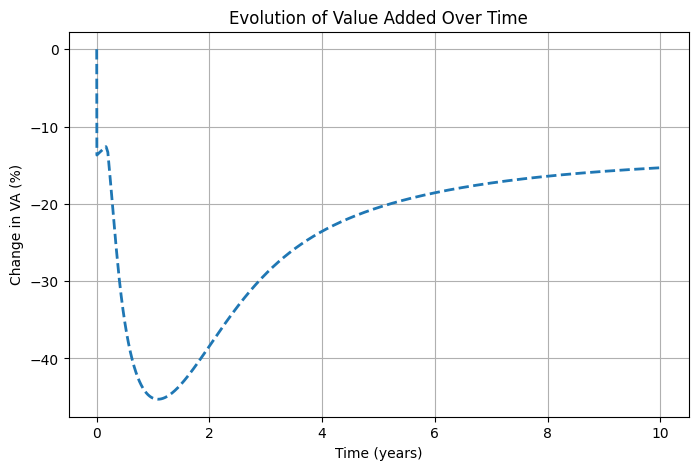

In [14]:
# Compute quarterly averages of VA
LengthMonth = int(np.floor(3.0 * 30.0 / 365.0 / Dtime)) + 1
NQu = int(np.floor(NStep * Dtime * 4.0))
VA_q = np.zeros((NQu, N))
for k in range(NQu):
    for n in range(N):
        for l in range(LengthMonth):
            VA_q[k, n] += VA[k * LengthMonth + l, n]
    VA_q[k, :] /= LengthMonth

# Compute relative VA (each time step relative to the initial VA)
VA_rel = np.zeros((NStep+1, N))
for i in range(NStep+1):
    for j in range(N):
        VA_rel[i, j] = VA[i, j] / VA[0, j]

# Annual VA and growth rates for 2004, 2005, and 2006
VA2004s = 365 * VA[0, :]
VA2005s = np.sum(VA[0:121, :], axis=0) + (365 - 120) * VA[0, :]
VA2006s = np.sum(VA[121:486, :], axis=0)
D0504 = (np.sum(VA2005s) - np.sum(VA2004s)) / np.sum(VA2004s) * 100
D0604 = (np.sum(VA2006s) - np.sum(VA2004s)) / np.sum(VA2004s) * 100

# Print diagnostic results
print('Total direct losses (million):', np.sum(Table_Dis_Louis))
totaldirect = np.sum(Table_Dis_Louis) + 1

total_VA_loss = (np.sum(VA) - (NStep+1) * np.sum(VA[0, :])) / 365.0
print('Total VA Losses (absolute, million):', total_VA_loss)
total = -total_VA_loss
totalratio = total / totaldirect
print('Total VA Losses (relative, %):', ((total_VA_loss / np.sum(VA[0, :])) * 100))
print('Per sector VA losses (absolute, million USD):', (np.sum(VA, axis=0) - (NStep+1) * VA[0, :]) / 365.0)
print('Growth 2005 vs 2004:', D0504)
print('Growth 2006 vs 2004:', D0604)

# Diagnostic Plot: Evolution of aggregate Value Added over time
Ref = np.sum(VA[0, :])
x1 = np.arange(NStep+1)
y1 = (np.sum(VA, axis=1) / Ref - 1) * 100
plt.figure(figsize=(8, 5))
plt.plot(x1/365.0, y1, '--', linewidth=2)
plt.xlabel('Time (years)')
plt.ylabel('Change in VA (%)')
plt.title('Evolution of Value Added Over Time')
plt.grid(True)
plt.show()


In [ ]:
from scipy.io import loadmat, savemat
def ARIO_version_4_1_NO(sens_ana=False, ampl=1.0, maxmax_surcapa=None, tau_alpha=None, NbJourStockU=None, Tau_Stock=None, Adj_prod=None):
    print('*******************************************************************')
    print('Adaptive Regional Input-Output (ARIO) model by Stéphane Hallegatte, version 4.1')
    print('Copyright (C) 2007-2009 Stéphane Hallegatte and Météo-France')
    print('Applied on the Louisiana economy and the landfall of Katrina (2005)')
    print('*******************************************************************')

    # Default parameters if not provided
    if maxmax_surcapa is None:
        maxmax_surcapa = 1.25*np.ones((1,15))
    if tau_alpha is None:
        tau_alpha = 1.0
    if NbJourStockU is None:
        NbJourStockU = 90
    if Tau_Stock is None:
        Tau_Stock = 30/365.0
    if Adj_prod is None:
        Adj_prod = 0.8

    # If no sensitivity analysis, reference parameters
    if not sens_ana:
        maxmax_surcapa = 1.25*np.ones((1,15))
        tau_alpha = 1.0
        NbJourStockU = 90
        Tau_Stock = 30/365.0
        ampl = 1.0
        Adj_prod = 0.8

    # time step = 1 day
    Dtime = 1/365.0
    # simulation length
    NStep = int(365*10)
    # number of sectors
    N = 15

    # Initialization of arrays
    OK = np.zeros((NStep+1,N))
    OK_final = np.zeros((NStep+1,N))
    actual_housing_loss = np.zeros((NStep+1,1))
    actual_prod = np.zeros((NStep+1,1))
    actual_Imports = np.zeros((NStep+1,N))
    actual_Exports = np.zeros((NStep+1,N))
    actual_Local_Dem = np.zeros((NStep+1,N))
    actual_Dem_Exports = np.zeros((NStep+1,N))
    actual_final_cons = np.zeros((NStep+1,N))
    actual_Sales = np.zeros((NStep+1,N))
    Final_Dem_Sat = np.zeros((NStep+1,N))
    actual_L = np.zeros((NStep+1,N))
    total_L = np.zeros(NStep+1)
    avalanche = np.zeros((NStep+1,1))
    Destr = np.zeros(N)
    Rec_stock = None  # This was not clearly used or saved in final results (3D array?), skipping
    Debt = np.zeros((NStep+1))
    prix = np.ones((NStep+1,N))
    payback = np.zeros((NStep+1))
    macro_effect = np.ones(NStep+1)
    Dem_recon_t = np.zeros((NStep,N))
    actual_reconstr = np.zeros((NStep+1,1))
    old_actual_final_cons = np.zeros((NStep+1,N))
    old_actual_recon_t = np.zeros((NStep,N))
    Sales_tot = np.zeros((NStep+1,N))
    Dem_reconstr = np.zeros((NStep+1,N,N))
    Budget = np.zeros(NStep+1)

    # reconstruction timescale
    tau_recon = 1/4.0
    # timescale of debt reimbursement
    tauR = 2.0
    epsilon = 1.e-6

    if sens_ana:
        print('Sensitivity analysis - Parameters:')
        print(ampl, maxmax_surcapa[0,0], tau_alpha, NbJourStockU, Tau_Stock, Adj_prod)

    # Load economic data from Louisiana.mat
    louis_data = loadmat('Louisiana.mat')
    ratio_K2Y = louis_data['ratio_K2Y'].ravel()
    T_Louis = louis_data['T_Louis'].ravel()
    L_Louis = louis_data['L_Louis'].ravel()
    IO_Table_Louis = louis_data['IO_Table_Louis']
    Imports_Louis = louis_data['Imports_Louis'].ravel()
    Exports_Louis = louis_data['Exports_Louis'].ravel()
    Local_Dem_Louis = louis_data['Local_Dem_Louis'].ravel()
    Job_Louis = louis_data['Job_Louis'].ravel()

    exchange_rate = 1.0
    T = T_Louis*exchange_rate
    L = L_Louis*exchange_rate
    IO = IO_Table_Louis*exchange_rate
    Imports = Imports_Louis*exchange_rate
    Exports = Exports_Louis*exchange_rate
    Local_Dem = Local_Dem_Louis*exchange_rate

    max_surcapa = np.ones(N)*1.0

    Imports_C = Local_Dem.copy()

    # Initialize actual_Imports_C
    actual_Imports_C = np.zeros(N)

    # Households and business insurance penetration
    penetration = 1.0
    penetrationf = 1.0

    alpha = 0.5
    wage = 1.0

    Conso = np.zeros(N)
    Sales = np.zeros(N)
    Profit = np.zeros((NStep+1,N))
    Prof_rate = np.zeros((NStep+1,N))
    VA = np.zeros((NStep+1,N))
    # initial situation
    for i in range(N):
        Conso[i] = 0
        for j in range(N):
            Conso[i] += IO[j,i]
        Sales[i] = 0
        for j in range(N):
            Sales[i] += IO[i,j]

    Sales_ini = Sales.copy()
    Produc = np.zeros((NStep+1,N))
    Long_Produc = np.zeros((NStep+1,N))
    for i in range(N):
        Produc[0,i] = Exports[i] + Local_Dem[i] + Sales[i]
        Long_Produc[0,i] = Produc[0,i]
        Profit[0,i] = Produc[0,i] - (Conso[i]+wage*L[i]+Imports[i])
        VA[0,i] = Produc[0,i] - Conso[i] - Imports[i]

    Assets = VA[0,:]*ratio_K2Y*exchange_rate
    Prof_rate[0,:] = Profit[0,:]/T
    Local_Dem_ini = Local_Dem.copy()
    Total_Local_Dem_ini = np.sum(Local_Dem_ini)
    Exports_ini = Exports.copy()
    actual_final_cons[0,:] = Local_Dem
    actual_prod[0] = np.sum(Produc[0,:])

    Pi = (1-alpha)*np.sum(Profit[0,:])
    DL_ini = wage*np.sum(L) + alpha*np.sum(Profit[0,:]) + Pi
    A_initial = IO

    # Substitution delays
    Sub_Del = np.ones(N)
    NoStock = np.zeros(N)

    # Inventories
    NbJourStock = NbJourStockU*np.ones(N)
    # Non-stockable goods
    # Utilities (index 2)
    NoStock[2] = 1
    NbJourStock[2] = 3.*NbJourStockU/60.
    # Transportation (index 5)
    NoStock[5] = 1
    NbJourStock[5] = 3.*NbJourStockU/60.
    # Construction sector (index 3)
    NbJourStock[3] = 365*100000

    Stock = np.zeros((N,N))
    Long_ST = np.zeros((N,N))
    Order = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            Stock[i,j] = IO[i,j]*NbJourStock[i]/365.0
            Long_ST[i,j] = Stock[i,j]
            Order[i,j] = IO[i,j]

    print('Economy data loaded')

    # Load disaster data
    kat_data = loadmat('Katrina_CBO_small.mat')
    Table_Katrina = kat_data['Table_Katrina']
    Table_Dis_Louis = np.zeros((N+1,N))
    for i in range(N+1):
        for j in range(N):
            Table_Dis_Louis[i,j] = Table_Katrina[i,j]*ampl

    Dem_reconstr_ini = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            Dem_reconstr_ini[i,j]=Table_Dis_Louis[i,j]

    Destr_capital_ini = np.sum(Dem_reconstr_ini,axis=1)
    Destr_ini = Destr_capital_ini/(ratio_K2Y*VA[0,:])
    Destr = Destr_ini.copy()
    mem_Destr = np.zeros((NStep+1,N))
    mem_Destr[0,:] = Destr

    print('Disaster data loaded')

    # Additional initializations
    Workers = np.zeros((NStep+1,N))
    actual_W = np.zeros((NStep+1,N))
    macro_effect[0] = 1.0
    # Adjusted production smoothing
    Adj_produc = Adj_prod*np.ones(N)
    Needed_Stock = np.zeros((N,N))
    Stock_target = np.zeros((N,N))
    Supply = np.zeros((N,N))
    mem_surcapa = np.zeros((NStep+1,N))
    mem_surcapa[0,:] = max_surcapa

    mem_dem_recon = np.zeros((NStep+1,N))
    mem_dem_export = np.zeros((NStep+1,N))
    mem_dem_local = np.zeros((NStep+1,N))
    mem_tot_order = np.zeros((NStep+1,N))
    mem_demand_total = np.zeros((NStep+1,N))
    mem_out_sec = np.zeros((NStep+1,N))
    mem_qui_out_sec = np.zeros((NStep+1,N))

    actual_recon_t = np.zeros((NStep+1,N))
    actual_recon_t[0,:] = 0.0
    mem_local_dem = np.zeros((NStep,N))
    rec_actual_Imports_C = np.zeros((NStep+1,N))

    for i in range(N):
        OK[0,i] = 1 - Destr[i]
        for j in range(N):
            Dem_reconstr[0,i,j] = Dem_reconstr_ini[i,j]

    actual_prod[0] = np.sum(Produc[0,:])
    total_L[0] = np.sum(L)
    actual_L[0,:] = L
    actual_Imports[0,:] = Imports
    actual_Exports[0,:] = Exports
    actual_Local_Dem[0,:] = Local_Dem
    cout = 0
    ini_profit = np.sum(Profit[0,:])
    tot_profit = np.zeros(NStep+1)
    tot_profit[0] = np.sum(Profit[0,:])
    reconstr_array = np.zeros((NStep+1,N))

    # MAIN LOOP
    print('Start simulation')
    for k in range(NStep):
        if (k%365)==364:
            print('year:', (k//365), ' completed')

        # Overproduction modeling
        if k>0:
            for i in range(N):
                if OK_final[k,i]<(1-epsilon):
                    max_surcapa[i]=max_surcapa[i]+Dtime/tau_alpha*(1-OK_final[k,i])*(maxmax_surcapa[0,i]-max_surcapa[i])
                if OK_final[k,i]>(1-epsilon):
                    max_surcapa[i]=max_surcapa[i]+(1-max_surcapa[i])*Dtime/tau_alpha
        mem_surcapa[k+1,:]=max_surcapa

        # Demand calculations
        for i in range(N):
            actual_Local_Dem[k+1,i] = macro_effect[k]*Local_Dem[i]
            actual_Imports_C[i] = macro_effect[k]*Imports_C[i]
            actual_Exports[k+1,i] = Exports[i]

            # Reconstruction demand
            Dem_recon_t[k,i] = 0
            for j in range(N):
                Dem_recon_t[k,i] += Dem_reconstr[k,j,i]

            if Dem_recon_t[k,i]>0:
                actual_recon_t[k+1,i]= Dem_recon_t[k,i]/tau_recon
            else:
                actual_recon_t[k+1,i]=0

            mem_dem_recon[k+1,i]=actual_recon_t[k+1,i]
            mem_dem_export[k+1,i]=actual_Exports[k+1,i]
            mem_dem_local[k+1,i] = actual_Local_Dem[k+1,i]

        Demand_total = np.zeros((NStep+1,N))
        Demand_total[k+1,:] = actual_Exports[k+1,:] + actual_Local_Dem[k+1,:] + actual_recon_t[k+1,:]

        for i in range(N):
            # Add intermediate consumption
            for j in range(N):
                Demand_total[k+1,i] += Order[i,j]
                mem_tot_order[k+1,i] += Order[i,j]
            Produc[k+1,i]=Demand_total[k+1,i]
            mem_demand_total[k+1,i]=Demand_total[k+1,i]

        # Production limits
        max_prod = np.maximum(0, max_surcapa*Produc[0,:]*(1-Destr))
        for i in range(N):
            if Produc[k+1,i]>max_prod[i]:
                Produc[k+1,i]=max_prod[i]
            OK_final[k+1,i]=min(1,Produc[k+1,i]/Demand_total[k+1,i])

        # Stocks constraint
        for j in range(N):
            out_sec = np.ones(N)
            for i in range(N):
                Needed_Stock[i,j] = Produc[k+1,j]/Produc[0,j]*IO[i,j]*NbJourStock[i]/365.0
                if Needed_Stock[i,j]>0:
                    if Stock[i,j]< (Adj_produc[i]*Needed_Stock[i,j]):
                        out_sec[i] = max(0,(1 - (Adj_produc[i]*Needed_Stock[i,j]-Stock[i,j])/(Adj_produc[i]*Needed_Stock[i,j])))

            Produc[k+1,j]=Produc[k+1,j]*np.min(out_sec)
            mem_out_sec[k+1,j]=Produc[k+1,j]
            mem_qui_out_sec[k+1,j]=np.argmin(out_sec)

        # Satisfied demands (full proportional rationing)
        for i in range(N):
            factor = Produc[k+1,i]/Demand_total[k+1,i]
            actual_recon_t[k+1,i]*=factor
            actual_Exports[k+1,i]*=factor
            actual_final_cons[k+1,i]= actual_Local_Dem[k+1,i]*factor
            for j in range(N):
                Supply[i,j] = Order[i,j]*factor
            Final_Dem_Sat[k+1,i]= (Produc[k+1,i] - Demand_total[k+1,i])

        # Update Stocks
        for i in range(N):
            for j in range(N):
                Stock[i,j]=max(epsilon,Stock[i,j]-Dtime*Produc[k+1,j]/Produc[0,j]*IO[i,j]+Dtime*Supply[i,j])

        # New Orders
        for i in range(N):
            for j in range(N):
                Stock_target[i,j] = min(Demand_total[k+1,j],max_prod[j])/Produc[0,j]*IO[i,j]*NbJourStock[i]/365.0
                tau_stock_target = 60.0/365.0
                Long_ST[i,j] = Long_ST[i,j] + Dtime/tau_stock_target*(Stock_target[i,j]-Long_ST[i,j])
                Order[i,j] = max(epsilon,Produc[k+1,j]/Produc[0,j]*IO[i,j] + (Long_ST[i,j]-Stock[i,j])/(Tau_Stock*NbJourStock[i]/NbJourStockU))

        for i in range(N):
            Conso[i]=0
            actual_Imports[k+1,i] = Imports[i]*Produc[k+1,i]/Produc[0,i]
            VA[k+1,i] = Produc[k+1,i] - actual_Imports[k+1,i]
            for j in range(N):
                if IO[j,i]>0:
                    VA[k+1,i]=VA[k+1,i] - IO[j,i]*Produc[k+1,i]/Produc[0,i]
                    Conso[i]+= prix[k+1,j]*IO[j,i]*Produc[k+1,i]/Produc[0,i]
            actual_W[k+1,i]=Job_Louis[i]*VA[k+1,i]/VA[0,i]
            actual_L[k+1,i]=L[i]*Produc[k+1,i]/Produc[0,i]
            Profit[k+1,i]= Produc[k+1,i]-(Conso[i]+actual_L[k+1,i]+actual_Imports[k+1,i])
            tot_profit[k+1]=np.sum(Profit[k+1,:])
            Prof_rate[k+1,i]=Profit[k+1,i]/T[i]

        total_L[k+1]=np.sum(actual_L[k+1,:])

        # Reconstruction modeling
        for i in range(N):
            if Destr[i]>0:
                # reduce Dem_reconstr
                val = Dem_reconstr[k,i,:]
                sum_val = np.sum(val)
                if sum_val>0:
                    fraction = actual_recon_t[k+1,i]/(Dem_recon_t[k,i]) if Dem_recon_t[k,i]>0 else 0
                    Dem_reconstr[k+1,i,:]=np.maximum(0, Dem_reconstr[k,i,:]-Dtime*val* fraction)
                reconstr_array[k+1,i]=max(0,np.sum(Dem_reconstr[k,i,:])-np.sum(Dem_reconstr[k+1,i,:]))

            Destr[i]= np.sum(Dem_reconstr[k+1,i,:])/Assets[i]
            mem_Destr[k+1,i]=Destr[i]

        actual_prod[k+1]=np.sum(Produc[k+1,:])

        # Household budget
        Budget[k+1] = Budget[k] + ((wage*np.sum(actual_L[k,:])+ alpha*tot_profit[k] + Pi)- np.sum(actual_Imports_C)- np.sum(actual_final_cons[k,:]))/12

        rec_actual_Imports_C[k+1,:]=actual_Imports_C
        macro_effect[k+1]=(DL_ini+12*(1/tauR)*Budget[k+1])/DL_ini
        mem_local_dem[k,:]=Local_Dem

    # End main loop

    # Compute results
    Dtime=1/365.0
    LengthMonth = int(np.floor(3.0*30.0/365.0/Dtime))+1
    NQu = int(np.floor(NStep*Dtime*4.0))
    VA_q = np.zeros((NQu,N))
    for k in range(NQu):
        for n in range(N):
            for l in range(LengthMonth):
                VA_q[k,n]+=VA[k*LengthMonth+l,n]
        VA_q[k,:]=VA_q[k,:]/LengthMonth

    VA_rel = np.zeros((NStep+1,N))
    for i in range(NStep+1):
        for j in range(N):
            VA_rel[i,j] = VA[i,j]/VA[0,j]

    VA2004s = (365)*VA[0,:]
    VA2005s = np.sum(VA[0:121,:],axis=0)+(365-120)*VA[0,:]
    VA2006s = np.sum(VA[121:486,:],axis=0)
    D0504 = (np.sum(VA2005s)-np.sum(VA2004s))/np.sum(VA2004s)*100
    D0604 = (np.sum(VA2006s)-np.sum(VA2004s))/np.sum(VA2004s)*100

    print('Total direct losses (million)')
    print(np.sum(Table_Dis_Louis))
    totaldirect=np.sum(Table_Dis_Louis)+1

    print('Total VA Losses (absolute, million, <0 is losses, >0 is gains)')
    print((np.sum(VA)- (NStep+1)*np.sum(VA[0,:]))/365.0)
    total=-(np.sum(VA)- (NStep+1)*np.sum(VA[0,:]))/365.0
    totalratio=total/totaldirect

    print('Total VA Losses (relative, %) <0 is losses, >0 gains')
    print((( (np.sum(VA)- (NStep+1)*np.sum(VA[0,:]))/365.0)/ (np.sum(VA[0,:])) )*100)

    print('Per sector VA losses (absolute, million USD, >0 losses, <0 gains)')
    print((np.sum(VA,axis=0)- (NStep+1)*VA[0,:])/365.0)

    print('growth 2005 vs 2004')
    print(D0504)
    print('growth 2006 vs 2004')
    print(D0604)

    # Optional plotting can be done with matplotlib
    # import matplotlib.pyplot as plt
    # fig, ax = plt.subplots()
    # Ref = np.sum(VA[0,:])
    # x1 = np.arange(3651)
    # y1 = (np.sum(VA[0:3651,:],axis=1)/Ref -1)*100
    # ax.plot(x1/365,y1,'--',linewidth=2)
    # ax.set_xlabel('Time (years)')
    # ax.set_ylabel('Change in VA (%)')
    # plt.show()

    # Save some results
    savemat('Results.mat', {
        'mem_out_sec':mem_out_sec, 'mem_qui_out_sec':mem_qui_out_sec, 'mem_surcapa':mem_surcapa,
        'mem_Destr':mem_Destr,'VA':VA,'VA_q':VA_q,'VA_rel':VA_rel,'Final_Dem_Sat':Final_Dem_Sat,
        'Demand_total':mem_demand_total,'Produc':Produc
    })
    print('Results saved in file "Results.mat"')

    return VA

In [ ]:
# Example call:
Res_VA = ARIO_version_4_1_NO()

*******************************************************************
Adaptive Regional Input-Output (ARIO) model by Stéphane Hallegatte, version 4.1
Copyright (C) 2007-2009 Stéphane Hallegatte and Météo-France
Applied on the Louisiana economy and the landfall of Katrina (2005)
*******************************************************************
Economy data loaded
Disaster data loaded
Start simulation
year: 0  completed
year: 1  completed
year: 2  completed
year: 3  completed
year: 4  completed
year: 5  completed
year: 6  completed
year: 7  completed
year: 8  completed
year: 9  completed
Total direct losses (million)
63091.09
Total VA Losses (absolute, million, <0 is losses, >0 is gains)
-316515.4016509786
Total VA Losses (relative, %) <0 is losses, >0 gains
-241.25553503108046
Per sector VA losses (absolute, million USD, >0 losses, <0 gains)
[ -2085.06757032 -37518.0786957  -14538.89920022  -5353.56026267
 -12467.11798077 -17193.44199403 -25887.0471596  -21036.08642217
  -9237.87255771 

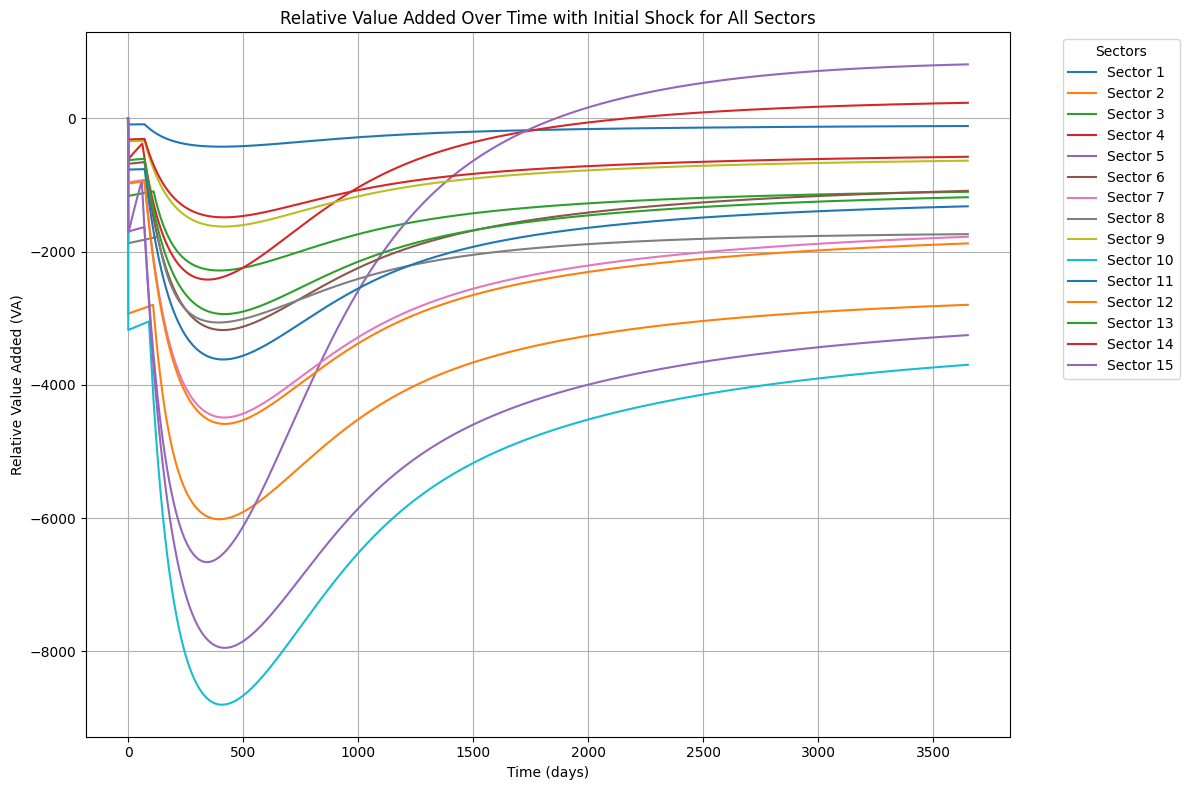

In [ ]:
import matplotlib.pyplot as plt
# Plot the time series for all sectors
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.plot(range(Res_VA.shape[0]), np.array([i - i[0] for i in Res_VA.T]).T[:, i], label=f"Sector {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Relative Value Added (VA)")
plt.title("Relative Value Added Over Time with Initial Shock for All Sectors")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Sectors")
plt.grid()
plt.tight_layout()
plt.show()